In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup
Here we define some output paths.

In [2]:
images = Path('datasets/test_imgs')
outputs = Path('outputs/test_imgs/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

2 mapping images


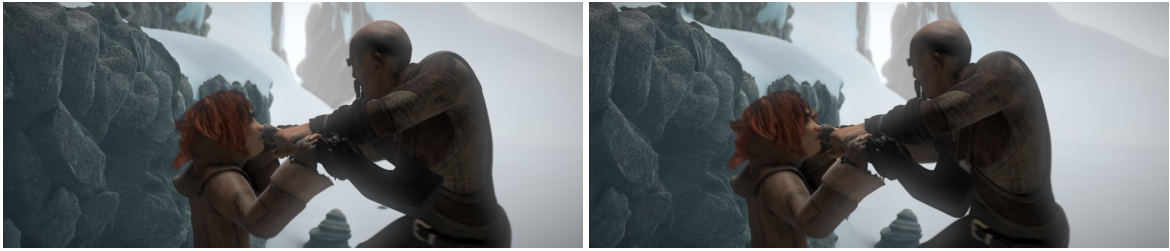

In [3]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25, figsize=10)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [4]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);
# pairs_from_exhaustive.main(sfm_pairs, image_list=references)
# match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/12/02 23:28:33 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
/home/tina/anaconda3/envs/dl_dev/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


  0%|          | 0/2 [00:00<?, ?it/s]

[2023/12/02 23:28:35 hloc INFO] Finished exporting features.
[2023/12/02 23:28:35 hloc INFO] Found 1 pairs.
[2023/12/02 23:28:35 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/home/tina/anaconda3/envs/dl_dev/lib/python3.8/site-packages/lightglue/lightglue.py:141: UserWarning: FlashAttention is not available. For optimal speed, consider installing torch >= 2.0 or flash-attn.
  self.inner_attn = Attention(flash)


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/12/02 23:28:38 hloc INFO] Finished exporting matches.


[['mapping/img1.jpg', 'mapping/img2.jpg']]


  0%|          | 0/1 [00:00<?, ?it/s]

2700


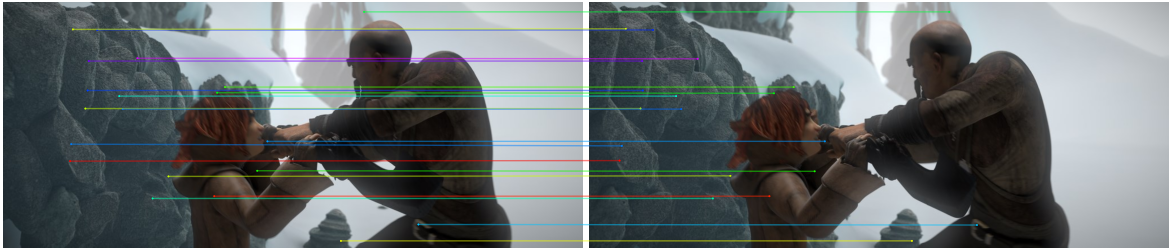

In [21]:
from hloc.utils.viz import plot_images, plot_matches
from hloc.utils.io import get_matches, get_keypoints
img1_name = 'mapping/img1.jpg'
img2_name = 'mapping/img2.jpg'
img1 = read_image(images / img1_name)
img2 = read_image(images / img2_name)
plot_images([img1, img2], dpi=25, figsize=10)
with open(str(sfm_pairs), 'r') as f:
    pairs = [p.split() for p in f.readlines()]
    print(pairs)
for name0, name1 in tqdm.tqdm(pairs):
    matches_info, _ = get_matches(matches, name0, name1)
    print(len(matches_info))
    kps1 = get_keypoints(features, img1_name, return_uncertainty=False)
    kps2 = get_keypoints(features, img2_name, return_uncertainty=False)
    idxs = np.random.choice(matches_info.shape[0], size=20)
    pts1 = kps1[matches_info[idxs,0]]
    pts2 = kps2[matches_info[idxs,1]]
    plot_matches(pts1, pts2, lw=4, ps=20, a=0.5)

In [22]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2023/12/03 00:09:37 hloc WARNING] The database already exists, deleting it.
[2023/12/03 00:09:37 hloc INFO] Creating an empty database...


[2023/12/03 00:09:37 hloc INFO] Importing images into the database...
[2023/12/03 00:09:37 hloc INFO] Importing features into the database...


  0%|          | 0/2 [00:00<?, ?it/s]

[2023/12/03 00:09:37 hloc INFO] Importing matches into the database...


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/12/03 00:09:37 hloc INFO] Performing geometric verification of the matches...
[2023/12/03 00:09:37 hloc INFO] Running 3D reconstruction...
[2023/12/03 00:09:37 hloc ERROR] Could not reconstruct any model!


In [46]:
import cv2
idxs = np.random.choice(matches_info.shape[0], size=400)
pts1 = kps1[matches_info[idxs,0]]
pts2 = kps2[matches_info[idxs,1]]
assert len(pts1) >= 5
E, mask = cv2.findEssentialMat(pts1, pts2, np.eye(3), method=cv2.RANSAC)
print(E)
n, R, t, _ = cv2.recoverPose(E, pts1, pts2, np.eye(3), 1e9, mask=mask)
print(n)
print(R)
print(t)

[[ 1.54091084e-08 -7.01349751e-05  2.76317244e-03]
 [ 6.13246611e-05  6.87046548e-06  7.07101380e-01]
 [-2.25984964e-03 -7.07103167e-01  6.79229863e-06]]
318
[[ 9.99999747e-01  7.11809534e-04  1.24905847e-05]
 [-7.11809414e-04  9.99999747e-01 -9.65464424e-06]
 [-1.24974538e-05  9.64575088e-06  1.00000000e+00]]
[[-9.99992360e-01]
 [ 3.90771498e-03]
 [ 9.92235509e-05]]


In [47]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]
print(len(pts1))

400


(436, 1024, 3)


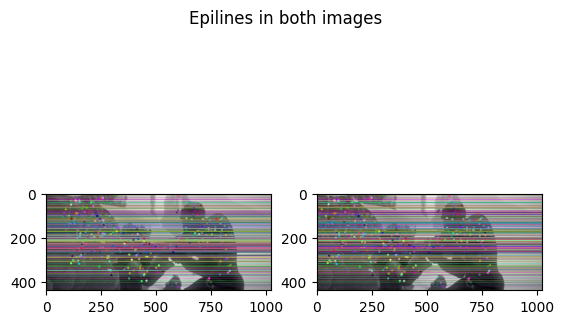

In [48]:
import matplotlib.pyplot as plt 
print(img1.shape)

def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

img1_g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1_g, img2_g, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2_g, img1_g, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

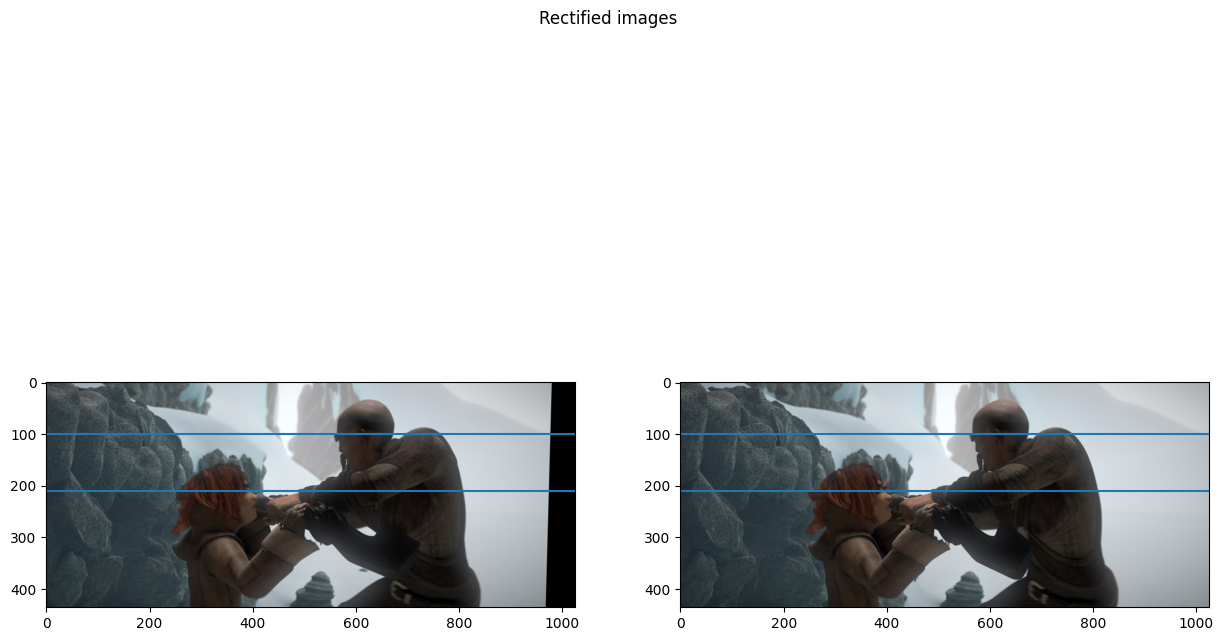

In [49]:
h1, w1 = img1_g.shape
h2, w2 = img2_g.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)

# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified)
axes[1].imshow(img2_rectified)
axes[0].axhline(100)
axes[1].axhline(100)
axes[0].axhline(210)
axes[1].axhline(210)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()